In [1]:
import numpy as np
import networkx as nx
import math
import random
from sklearn.cluster import KMeans
from typing import List
import matplotlib

WAREHOUSE_COLOR = 'magenta'
def get_truck_colors(n_trucks : int) -> List[str]:
    cmap = matplotlib.colormaps['turbo']
    color_rgba  = cmap(np.linspace(0.0,1.0,n_trucks))
    colors_hex = []
    for c in color_rgba:
        
        colors_hex.append('#{:02x}{:02x}{:02x}'.format(*(c*255).astype(int)))
    return colors_hex

class VRP:
    def __init__(self,map_width : float , map_height : float, n_clients : int, n_trucks : int, warehouse_loc : tuple[float,float] = None) :
        self.n_clients = n_clients
        self.n_trucks = n_trucks
        self.POPULATION_SIZE = 100
        if warehouse_loc is None:
            self.warehouse_loc = (random.random()*map_width,random.random()*map_height)
        else:
            self.warehouse_loc = warehouse_loc
        self.population = np.zeros((self.POPULATION_SIZE,n_clients),dtype=int)
        #GRAPH
        client_locations_x = np.random.random((n_clients,1))*map_width
        client_locations_y = np.random.random((n_clients,1))*map_height
        self.client_locations = np.hstack([client_locations_x,client_locations_y])
        self.graph = nx.Graph()
        for i,(x,y) in enumerate(self.client_locations):
            self.graph.add_node(i,pos=(x,y))
        self.graph.add_node(-1,pos=self.warehouse_loc)
        
        for i,(x,y) in enumerate(self.client_locations):
            self.graph.add_edge(i,-1,weight = math.sqrt((self.warehouse_loc[0]-x)**2+(self.warehouse_loc[1]-y)**2),color='r')

            
        #TODO: renderlo piu efficiente con n*(n-1)/2
        for i,(x,y) in enumerate(self.client_locations):
            for j,(xx,yy) in enumerate(self.client_locations):
                if i!= j:
                    self.graph.add_edge(i,j,weight = math.sqrt((xx-x)**2+(yy-y)**2))
                    
    def draw_problem(self, show_edges : bool = False):
        node_color = []
        for node in self.graph:
            node_color.append("yellow" if node == -1 else "coral")
        if show_edges:
            nx.draw(self.graph, nx.get_node_attributes(self.graph, 'pos'), with_labels=True, node_size=150,node_color = node_color)
        else:
            nx.draw_networkx_nodes(self.graph, nx.get_node_attributes(self.graph, 'pos'), node_size=100,node_color = node_color)
            
    def init_random_population(self):
        self.population = np.random.randint(0, self.n_trucks, size=(self.POPULATION_SIZE,self.n_clients))
        
    def init_kmeans_population(self,random_init_p : float = 0.0):
        locs = [ (loc[0],loc[1]) for loc in self.client_locations]
        #locs.append(self.warehouse_loc)
        for i in range(self.POPULATION_SIZE):
            if random.random() < random_init_p:
                self.population[i] = np.random.randint(0, self.n_trucks, size=(self.n_clients))
            else:
                kmeans = KMeans(n_clusters=self.n_trucks,n_init='auto',max_iter=1,init='random').fit(locs)
                self.population[i]= kmeans.predict(locs)
            
        
    def draw_chromosome(self,chromosome_index : int = 0):
        colors = get_truck_colors(self.n_trucks)
        node_color_map = []
        for client,truck in enumerate(self.population[chromosome_index]):
            node_color_map.append(colors[truck])
        drawn_nodes = list(self.graph.nodes)
        drawn_nodes.remove(-1)
        nx.draw_networkx_nodes(self.graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = drawn_nodes,node_color = node_color_map)
        nx.draw_networkx_nodes(self.graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = [-1],node_color = WAREHOUSE_COLOR)
        
    def draw_chromosome_paths(self,chromosome_index : int = 0, approximate : bool = False):
        colors = get_truck_colors(self.n_trucks)
        node_color_map = []
        for client,truck in enumerate(self.population[chromosome_index]):
            node_color_map.append(colors[truck])
        tsp_graph = nx.Graph()
        for i,(x,y) in enumerate(self.client_locations):
            tsp_graph.add_node(i,pos=(x,y))
        tsp_graph.add_node(-1,pos = self.warehouse_loc)
        for truck in range(self.n_trucks):
            
            indices = np.where(self.population[chromosome_index] == truck)[0]
            #random_path[indices]
            indices = np.append(indices,[-1])
            if approximate:
                g = nx.subgraph(self.graph,indices)
                tsp_solution = nx.approximation.traveling_salesman.simulated_annealing_tsp(g,init_cycle='greedy',temp = 5000)
            else:
                tsp_solution = nx.approximation.traveling_salesman_problem(self.graph,nodes = indices)
            
            #list(indices)
            for i in range(len(tsp_solution)-1):
                tsp_graph.add_edge(tsp_solution[i],tsp_solution[i+1])
        edge_color = []
        for e in tsp_graph.edges():
            edge_color.append(node_color_map[e[0] if e[0]!=-1 else e[1]])

        drawn_nodes = list(self.graph.nodes)
        drawn_nodes.remove(-1)
        nx.draw_networkx_nodes(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = drawn_nodes,node_color = node_color_map)
        nx.draw_networkx_nodes(self.graph,nx.get_node_attributes(self.graph, 'pos'),nodelist = [-1],node_color = WAREHOUSE_COLOR)
        nx.draw_networkx_edges(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),edge_color=edge_color)


CPU times: user 407 ms, sys: 11.7 ms, total: 419 ms
Wall time: 69.9 ms


/tmp/ipykernel_7037/4121095079.py:112: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),edge_color=edge_color)


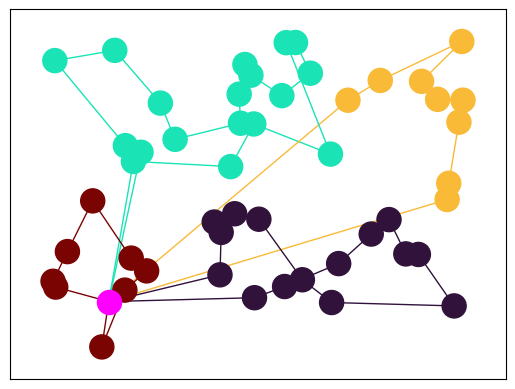

In [5]:
vrp = VRP(200,200,50,n_trucks=4)
#vrp.draw_problem(True)

#vrp.init_random_population()
vrp.init_kmeans_population(random_init_p=0.10)
#print(vrp.population)

%time vrp.draw_chromosome_paths(chromosome_index=2,approximate = False)

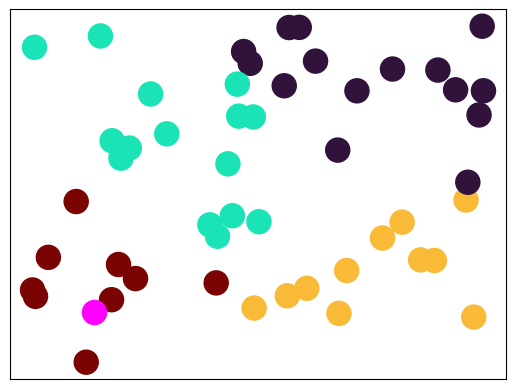

In [6]:
vrp.draw_chromosome()

/tmp/ipykernel_7037/4121095079.py:112: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tsp_graph,nx.get_node_attributes(self.graph, 'pos'),edge_color=edge_color)


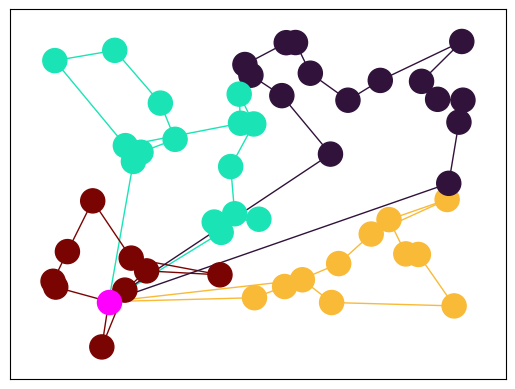

In [7]:
vrp.draw_chromosome_paths()

In [8]:
vrp.population[0]

array([1, 3, 2, 1, 0, 3, 2, 0, 0, 2, 1, 3, 1, 0, 1, 1, 0, 2, 1, 2, 2, 0,
       2, 3, 1, 2, 1, 2, 1, 2, 0, 0, 0, 3, 1, 1, 0, 3, 0, 1, 0, 1, 3, 2,
       0, 0, 3, 3, 1, 0])